# Target dataset

- where do we draw a line between smoothing and linking?
    - sub 10GeV
    - 3-5cm cone

- need a step in between CLUE3D output and simulation

In [12]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from reco.plotting import plot_sim_reco, plot_tracksters
from reco.dataset import match_trackster_pairs, get_ground_truth
from reco.evaluation import evaluate
from reco.distance import get_z_map


# %matplotlib widget
%matplotlib inline

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_8.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

plt.style.use('seaborn-whitegrid')

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_path: "ticlNtuplizer/graph"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)

E_TH = 10

Events per file: 100


In [8]:
eid = 0
z_map = get_z_map(data_root)
gt = get_ground_truth(tracksters, simtracksters, associations, eid, z_map=z_map)

print(
    "Reco:", len(tracksters["vertices_x"].array()[eid]),
    "Sim:", len(simtracksters["stsSC_vertices_x"].array()[eid]),
    "Target:", len(gt["vertices_x"]) 
)

Reco: 333 Sim: 24 Target: 138


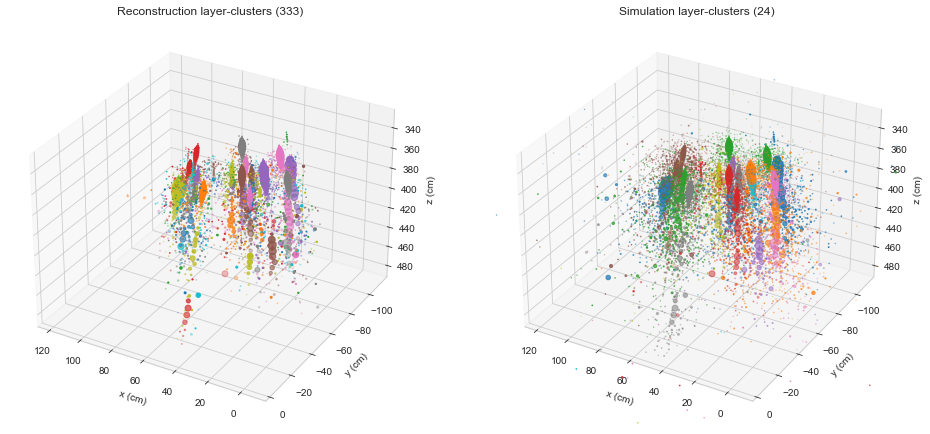

In [9]:
# RECO vs SIM
plot_sim_reco(
    tracksters["vertices_x"].array()[eid],
    tracksters["vertices_y"].array()[eid],
    tracksters["vertices_z"].array()[eid],
    tracksters["vertices_energy"].array()[eid],
    simtracksters["stsSC_vertices_x"].array()[eid],
    simtracksters["stsSC_vertices_y"].array()[eid],
    simtracksters["stsSC_vertices_z"].array()[eid],
    simtracksters["stsSC_vertices_energy"].array()[eid],
    simtracksters["stsSC_vertices_indexes"].array()[eid],
    simtracksters["stsSC_vertices_multiplicity"].array()[eid],
    legend=False,
    figsize=(16, 10),
)

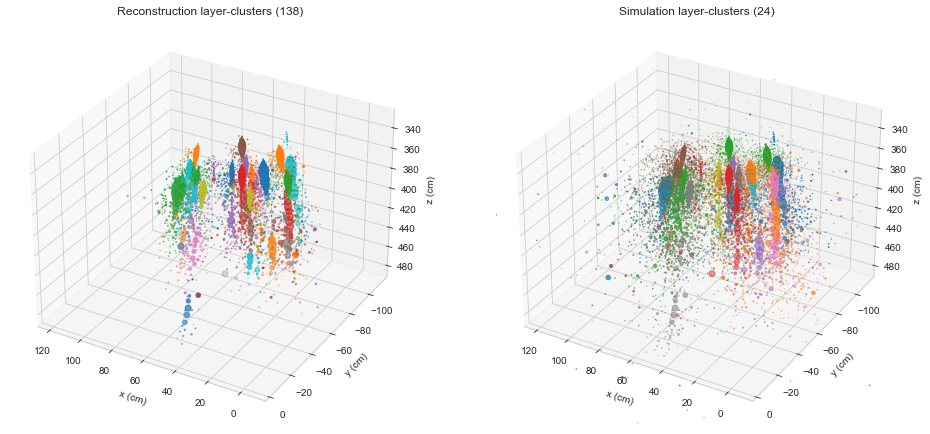

In [10]:
# Target vs SIM
plot_sim_reco(
    gt["vertices_x"],
    gt["vertices_y"],
    gt["vertices_z"],
    gt["vertices_energy"],
    simtracksters["stsSC_vertices_x"].array()[eid],
    simtracksters["stsSC_vertices_y"].array()[eid],
    simtracksters["stsSC_vertices_z"].array()[eid],
    simtracksters["stsSC_vertices_energy"].array()[eid],
    simtracksters["stsSC_vertices_indexes"].array()[eid],
    simtracksters["stsSC_vertices_multiplicity"].array()[eid],
    legend=False,
    figsize=(16, 10),
)

## Getting the ground truth params right

Find which configuration does the best job improving the reconstruction

In [13]:
# explore the parameter
ex = tracksters["vertices_x"].array()
ey = tracksters["vertices_y"].array()
ez = tracksters["vertices_z"].array()
ee = tracksters["vertices_energy"].array()
ei = tracksters["vertices_indexes"].array()
em = tracksters["vertices_multiplicity"].array()

sei = simtracksters["stsSC_vertices_indexes"].array()
see = simtracksters["stsSC_vertices_energy"].array()
sem = simtracksters["stsSC_vertices_multiplicity"].array()

precision_diff = []
recall_diff = []
fscore_diff = []

ng = []
nc = []
ns = []

for eid in range(5):
    gt = get_ground_truth(
        tracksters,
        simtracksters,
        associations,
        eid,
        energy_threshold=15,
        distance_threshold=30,
        z_map=z_map
    )

    gti = gt["vertices_indexes"]
    gte = gt["vertices_energy"]
    gtm = gt["vertices_multiplicity"]

    c2sP, c2sR, c2sF = evaluate(ei[eid], sei[eid], ee[eid], see[eid], em[eid], sem[eid], noise=False)
    g2sP, g2sR, g2sF = evaluate(gti, sei[eid], gte, see[eid], gtm, sem[eid], noise=False)

    print(f"{eid}:\tP {c2sP:.2f}/{g2sP:.2f}\t| R {c2sR:.2f}/{g2sR:.2f}\t| F {c2sF:.2f}/{g2sF:.2f}")

    precision_diff.append(c2sP - g2sP)
    recall_diff.append(c2sR - g2sR)
    fscore_diff.append(c2sF - g2sF)

    ng.append(len(gt["vertices_indexes"]))
    nc.append(len(ee[eid]))
    ns.append(len(sei[eid]))

0:	P 0.82/0.83	| R 0.15/0.37	| F 0.18/0.42
1:	P 0.86/0.87	| R 0.18/0.38	| F 0.21/0.43
2:	P 0.90/0.90	| R 0.25/0.44	| F 0.29/0.49
3:	P 0.86/0.87	| R 0.14/0.37	| F 0.16/0.42
4:	P 0.88/0.89	| R 0.23/0.37	| F 0.26/0.42


In [16]:
print(f"Precision loss:\t{sum(precision_diff):.3f}\tavg: {np.mean(precision_diff):.3f}")
print(f"Recall loss:\t{sum(recall_diff):.3f}\tavg: {np.mean(recall_diff):.3f}")
print(f"Fscore loss:\t{sum(fscore_diff):.3f}\tavg: {np.mean(fscore_diff):.3f}")

Precision loss:	-0.047	avg: -0.009
Recall loss:	-0.989	avg: -0.198
Fscore loss:	-1.059	avg: -0.212


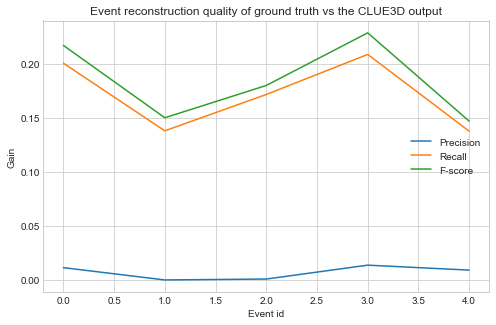

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(-np.array(precision_diff), label="Precision")
plt.plot(-np.array(recall_diff), label="Recall")
plt.plot(-np.array(fscore_diff), label="F-score")
plt.ylabel("Gain")
plt.title("Event reconstruction quality of ground truth vs the CLUE3D output")
plt.xlabel("Event id")
plt.legend()
plt.show()

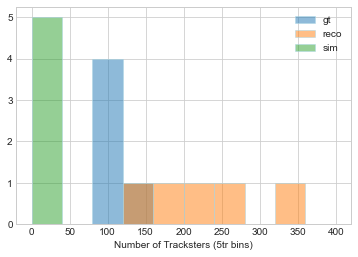

In [ ]:
plt.hist(ng, bins=10, edgecolor="lightblue", range=(0, 400), label="gt", alpha=0.5)
plt.hist(nc, bins=10, edgecolor="lightblue", range=(0, 400), label="reco", alpha=0.5)
plt.hist(ns, bins=10, edgecolor="lightblue", range=(0, 400), label="sim", alpha=0.5)
plt.xlabel("Number of Tracksters (5tr bins)")
plt.legend()
plt.show()